In [95]:
import pandas as pd
import numpy as np
from statistics import mean
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `scripts/stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [96]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride
...,...,...,...,...,...,...,...,...,...,...
2019-07-19 20:22:49+00:00,NaN,3.0,166.8,True,58.2,174,666.00 m,16,136,Ride
2019-07-26 20:12:56+00:00,120.8,7.0,166.9,True,59.6,185,663.00 m,15,139,Ride
2019-07-27 20:42:59+00:00,122.0,3.0,168.4,True,19.8,49,247.00 m,6,47,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [97]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()


,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [98]:
result = pd.merge(cheetah, strava, left_index=True, right_index=True, how='inner')

## Required Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
    
* Some of the rides are designated as "Race" in the `workout_type` field, these are where I am racing and you might expect that these would be the most challenging rides.  Normalised Power (NP) is a good measure of how hard a ride is.  Explore the values of `NP` for races vs the overall set of rides to see if this hypothesis is supported (use graphs and summary statistics).  Are races more challenging than rides in general? 

* It is useful to see a summary of rides over the year. Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

## Challenge

* What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

* Generate another summary graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.


In [99]:
#Question 1
result[result.device_watts==True]

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
2018-01-27 19:39:49+00:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.754520,16.6520,1.31920,1.67755,223.621,0.834410,...,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride
2018-01-27 20:01:32+00:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.843430,80.2669,1.21137,1.54250,246.185,0.918600,...,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race
2018-02-05 21:06:42+00:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.827140,78.8866,1.35775,1.86002,254.409,0.949290,...,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride
2018-02-07 06:59:05+00:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.814220,159.4590,1.47188,1.74658,233.780,0.872310,...,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride
2018-02-09 19:18:03+00:00,02/10/18,06:18:03,2018_02_10_06_18_03.json,189.918,0.708650,125.8670,1.31962,1.54810,212.977,0.794690,...,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-19 20:22:49+00:00,07/20/19,06:22:49,2019_07_20_06_22_49.json,204.799,0.764175,140.7350,1.24317,0.00000,222.990,0.832052,...,NaN,3.0,166.8,True,58.2,174,666.00 m,16,136,Ride
2019-07-26 20:12:56+00:00,07/27/19,06:12:56,2019_07_27_06_12_56.json,209.935,0.783340,151.5300,1.28248,1.74567,236.254,0.881543,...,120.8,7.0,166.9,True,59.6,185,663.00 m,15,139,Ride
2019-07-27 20:42:59+00:00,07/28/19,06:42:59,2019_07_28_06_42_59.json,193.017,0.720214,42.8943,1.19066,1.58605,212.345,0.792332,...,122.0,3.0,168.4,True,19.8,49,247.00 m,6,47,Ride
2019-07-27 21:47:24+00:00,07/28/19,07:47:24,2019_07_28_07_47_24.json,251.993,0.940274,74.0446,1.07162,1.74483,268.022,1.000080,...,144.4,3.0,235.2,True,29.1,50,415.00 m,15,50,Race


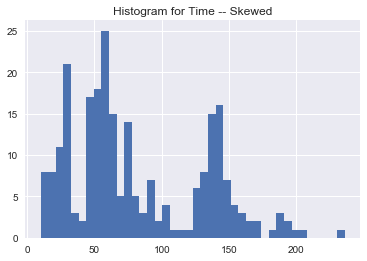

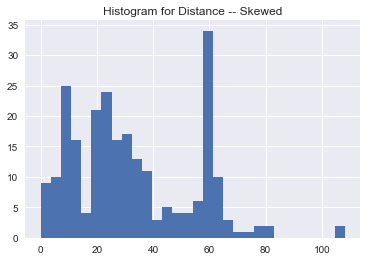

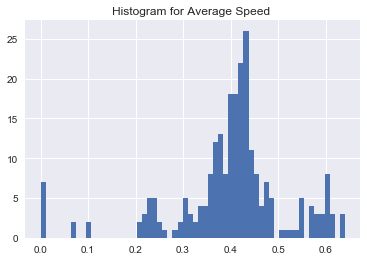

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


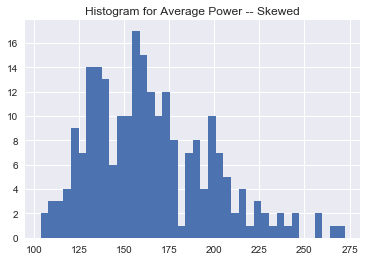

In [100]:
#Question 2
plt.hist(result.moving_time,bins=40)
plt.title('Histogram for Time -- Skewed')
plt.show() #seems to show skewed

plt.hist(result.distance,bins=30)
plt.title('Histogram for Distance -- Skewed')
plt.show() #seems to show skewed

plt.hist((result.distance/result.moving_time),bins=60)
plt.title('Histogram for Average Speed ')
plt.show() #seems to show Normal distribution

plt.hist(result.average_watts,bins=40)
plt.title('Histogram for Average Power -- Skewed')
plt.show() #seems to show skewed







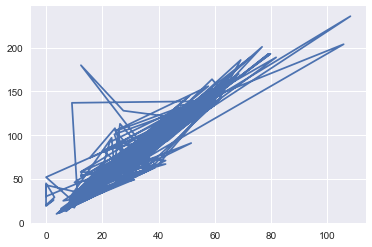

In [180]:
#Question 3
plt.plot(result.distance,result.moving_time)
plt.show()



/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


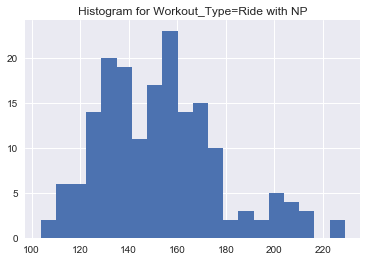

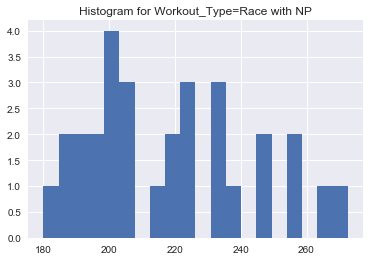

Average Value of NP for Ride: 
152.86307692307693
Average Value of NP for Race: 
219.1074074074074
Conclusion: by the look from both histogram the NP value for Race seems to be higher the overall distribution of Ride is value of below 5 after 180 in x Axis and most values in 160 range. Where as the values of NP in Race is cosistent with most values at around 200 range. The average value also indicates the higher value. Hence the hypothesis claimed is correct.


In [102]:
#Question 4
ride=result[result.workout_type=='Ride']
race=result[result.workout_type=='Race']

plt.hist(ride.average_watts,bins=20)
plt.title('Histogram for Workout_Type=Ride with NP')
plt.show()

plt.hist(race.average_watts,bins=20)
plt.title('Histogram for Workout_Type=Race with NP')
plt.show()
print('Average Value of NP for Ride: ')
forsum=ride.dropna()
print(mean(forsum.average_watts))

print('Average Value of NP for Race: ')
forsum=race.dropna()
print(mean(forsum.average_watts))

print("Conclusion: by the look from both histogram the NP value for Race seems to be higher the overall distribution of Ride is value of below 5 after 180 in x Axis and most values in 160 range. Where as the values of NP in Race is cosistent with most values at around 200 range. The average value also indicates the higher value. Hence the hypothesis claimed is correct.")






In [103]:
#Question 5

2018-01-28 06:39:49+11:00


In [185]:
#Question 5
result.date = pd.to_datetime(result.date)
print("Below result is distance printed by month year and date is mentioned kindly ignore the date")

c=result.groupby(pd.Grouper(key='date', freq='M')).distance.sum().sort_values()

Below result is distance printed by month year and date is mentioned kindly ignore the date


In [186]:

print(c)


date
2018-01-31     46.2
2018-07-31    190.0
2018-06-30    193.4
2018-09-30    204.9
2018-08-31    214.9
2018-05-31    339.5
2019-07-31    367.2
2019-01-31    423.2
2018-10-31    440.7
2018-04-30    450.2
2018-02-28    476.8
2019-02-28    494.9
2018-03-31    508.0
2019-06-30    522.6
2019-03-31    552.0
2018-12-31    585.1
2019-05-31    610.1
2019-04-30    640.4
2018-11-30    692.6
Name: distance, dtype: float64


In [155]:

result["avgspeed"]=result.distance/result.moving_time

b=result.groupby(pd.Grouper(key='date', freq='M')).avgspeed.sum().sort_values()

Below result is average speed printed by month year and date is mentioned kindly ignore the date


In [157]:
print("Below result is average speed printed by month year and date is mentioned kindly ignore the date")
print(b)

Below result is average speed printed by month year and date is mentioned kindly ignore the date
date
2018-01-31    1.023178
2018-07-31    1.479644
2018-09-30    2.028879
2018-06-30    2.280879
2018-08-31    2.722842
2018-05-31    3.533776
2018-04-30    4.687672
2019-07-31    4.950248
2019-01-31    5.125014
2018-10-31    5.375410
2018-03-31    5.524653
2018-02-28    5.966531
2018-12-31    6.228917
2019-03-31    6.342045
2019-02-28    6.901090
2019-05-31    7.868224
2019-06-30    7.917680
2019-04-30    8.377178
2018-11-30    8.752051
Name: avgspeed, dtype: float64


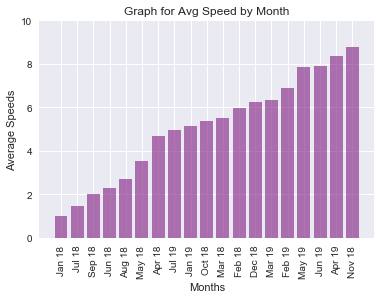

Average of all Months Avg Speed


5.10978484433258

In [194]:
arrayaxis=["Jan 18","Jul 18","Sep 18","Jun 18","Aug 18","May 18","Apr 18","Jul 19","Jan 19","Oct 18","Mar 18","Feb 18","Dec 18","Mar 19","Feb 19","May 19","Jun 19","Apr 19","Nov 18"]

y_pos = np.arange(len(arrayaxis))
 
# Create bars and choose color
plt.bar(y_pos, b, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Graph for Avg Speed by Month')
plt.xlabel('Months')
plt.ylabel('Average Speeds')
 
# Limits for the Y axis
plt.ylim(0,10)
 
# Create names
plt.xticks(y_pos, arrayaxis,rotation=90)
 
# Show graphic
 
# Show graphic
plt.show()

print("Average of all Months Avg Speed")
mean(b)


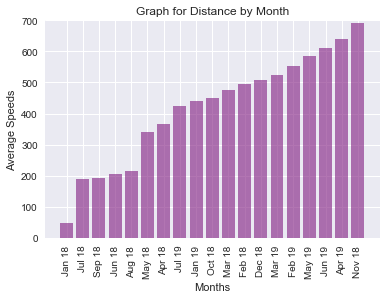

In [192]:
y_pos = np.arange(len(arrayaxis))
 
# Create bars and choose color
plt.bar(y_pos, c, color = (0.5,0.1,0.5,0.6))

# Add title and axis names
plt.title('Graph for Distance by Month')
plt.xlabel('Months')
plt.ylabel('Average Speeds')
 
# Limits for the Y axis
plt.ylim(0,700)
 
# Create names
plt.xticks(y_pos, arrayaxis,rotation=90)
 
# Show graphic
 
# Show graphic
plt.show()

